In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sys
import os


sys.path.append(os.path.abspath("../src"))

from utils.config import MID_X, MID_Y, SCREEN_HEIGHT, SCREEN_WIDTH

def determine_position(pos_x, pos_y):
    """Détermine la position du regard en pixels."""
    if pos_x < MID_X and pos_y < MID_Y:
        return "Top Left"
    elif pos_x > MID_X and pos_y < MID_Y:
        return "Top Right"
    elif pos_x < MID_X and pos_y > MID_Y:
        return "Bottom Left"
    elif pos_x > MID_X and pos_y > MID_Y:
        return "Bottom Right"
    else:
        return "Center"


def plot_experiments_bee(file):
    plt.xlim(0,SCREEN_WIDTH)
    plt.ylim(0,SCREEN_HEIGHT)
    
    with open(f"../src/experiments/{file}", "rb") as fd:
        l_pos = pickle.load(fd)
        
    l_pos = np.array(l_pos)

    quandrant_colors = { "Top Left": "blue", 
                        "Top Right" : "red",  
                        "Bottom Left" : "green", 
                        "Bottom Right" : "yellow", 
                        "Center" : "black"}
    
    quadrant_labels = [determine_position(x,y) for x,y in l_pos]
    colors = [quandrant_colors[label] for label in quadrant_labels]
    
    plt.scatter(l_pos[:,0],l_pos[:,1], edgecolors='k',c=colors, alpha=0.75)
    plt.scatter(MID_X,MID_Y,color=['black'],marker='8',s=80,edgecolors="black")
    
    plt.axvline(x=MID_X, color='black', linestyle='--', linewidth=1)
    plt.axhline(y=MID_Y, color='black', linestyle='--', linewidth=1)
    
    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=quandrant_colors[q])
                          for q in quandrant_colors.keys()]
    plt.legend(handles,quandrant_colors.keys(),loc='center left', bbox_to_anchor=(1, 0.5))

    plt.gca().invert_yaxis()

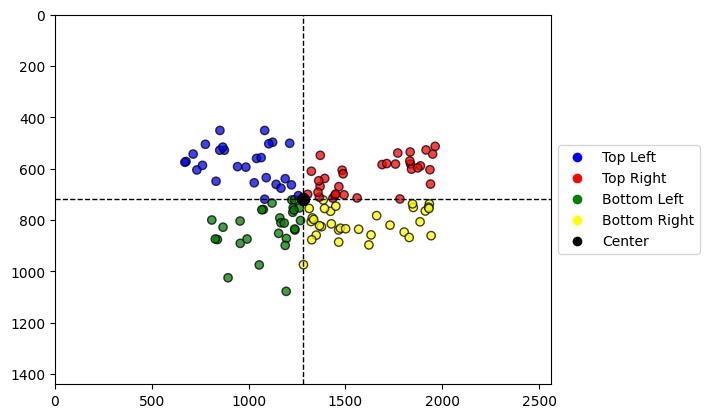

In [2]:
plot_experiments_bee("gaze_2025-02-19_06-11-22.pkl")

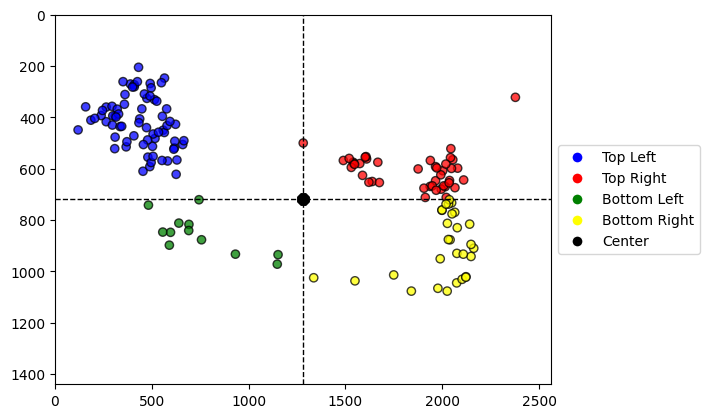

In [3]:
plot_experiments_bee("gaze_2025-02-20_09-58-46.pkl")

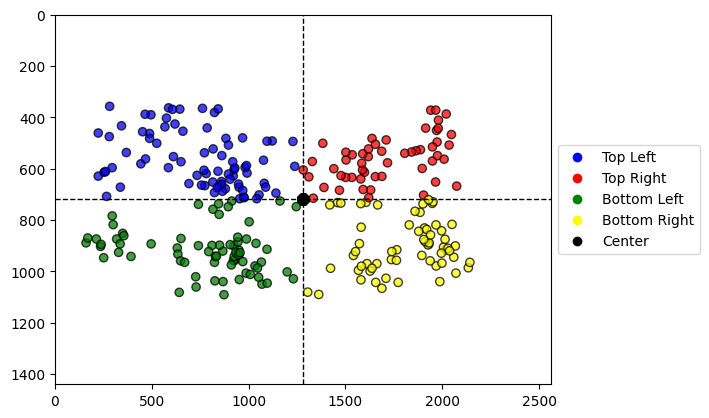

In [6]:
plot_experiments_bee("gaze_2025-02-28_04-57-25.pkl")

In [ ]:
# utils_figs.py
import os, math, statistics as stats
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)

# -------------------------------------------------------------------
# Conversion / dénormalisation
# -------------------------------------------------------------------

def cm_to_pixels(x_cm, y_cm, W=2560, H=1440):
    """
    Conversion de l'espace métrique (cm) d'iTracker -> pixels écran.
    x_px = ((25 + x_cm) / (2*25)) * W
    y_px = ((25 - y_cm) / (2*25)) * H
    """
    x_px = ((25.0 + x_cm) / 50.0) * W
    y_px = ((25.0 - y_cm) / 50.0) * H
    return x_px, y_px

def batch_cm_to_pixels(xy_cm, W=2560, H=1440):
    return [cm_to_pixels(x, y, W, H) for (x, y) in xy_cm]

def denorm_pixels(xy_norm, W=2560, H=1440):
    """
    Dénormalisation de l'espace [0,1]^2 -> pixels écran.
    """
    return [(x * W, y * H) for (x, y) in xy_norm]

# -------------------------------------------------------------------
# Mesures et traces
# -------------------------------------------------------------------

def euclid_errors(xy_true, xy_pred):
    errs = []
    for (tx, ty), (px, py) in zip(xy_true, xy_pred):
        errs.append(math.hypot(px - tx, py - ty))
    return errs

def pairs_plot(xy_true, xy_pred, title, xlabel, ylabel, outpath,
               screen_size=(2560, 1440), origin_top_left=True,
               draw_screen_border=True):
    """
    Scatter GT vs prédictions avec segments pairés.
    - Les axes sont bornés à la taille écran (W,H) fournie.
    - Le rapport d'aspect respecte H/W (pas de visuel "carré").
    - Option pour inverser Y (origine en haut à gauche, comme en pixels).
    """
    W, H = screen_size

    
    base_width = 8.0 
    fig_height = base_width * (H / W)
    fig, ax = plt.subplots(figsize=(base_width, fig_height))

    
    for (tx, ty), (px, py) in zip(xy_true, xy_pred):
        ax.plot([tx, px], [ty, py], linestyle="--", linewidth=1, color="#8c8c8c")

    
    txs, tys = zip(*xy_true)
    pxs, pys = zip(*xy_pred)
    ax.scatter(txs, tys, marker="x", s=60, label="Vérité terrain (GT)")
    ax.scatter(pxs, pys, marker="x", s=60, label="Prédiction modèle")

    
    ax.set_xlim(0, W)
    if origin_top_left:
        ax.set_ylim(H, 0) 
    else:
        ax.set_ylim(0, H)

    
    try:
        ax.set_box_aspect(H / W)
    except Exception:
        ax.set_aspect(W / H, adjustable="box")

    
    if draw_screen_border:
        rect = plt.Rectangle((0, 0), W, H,
                             fill=False, linewidth=1.2, linestyle=":",
                             edgecolor="#444444")
        ax.add_patch(rect)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle=":")

    # Légende hors axes
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)

    plt.tight_layout()
    fig.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close(fig)
    
def error_hist_with_stats(errors, unit_label, title, outpath,
                          mean_color="#d62728", median_color="#6f2dbd",
                          band_color="#f1c40f"):
    """
    Histogramme avec mean (ligne pleine), median (pointillée) et bande ±1 sigma (remplie).
    Légende positionnée en dehors de l'axe.
    """
    m = stats.mean(errors)
    s = stats.pstdev(errors) if len(errors) > 1 else 0.0  # écart-type population
    med = stats.median(errors)

    plt.figure(figsize=(8.5, 4.8))
    
    plt.hist(errors, bins="auto", edgecolor="black", alpha=0.65)

    
    left, right = m - s, m + s
    plt.axvspan(left, right, color=band_color, alpha=0.25, label="± 1 écart-type")

    
    plt.axvline(m, color=mean_color, linewidth=2, label=f"Moyenne = {m:.2f} {unit_label}")
    plt.axvline(med, color=median_color, linestyle="--", linewidth=2,
                label=f"Médiane = {med:.2f} {unit_label}")

    plt.title(title)
    plt.xlabel(f"Distance euclidienne ({unit_label})")
    plt.ylabel("Fréquence")
    plt.grid(True, linestyle=":")
    
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close()

def simple_curve(y_values, title, xlabel, ylabel, outpath):
    """
    Courbe simple (perte par époque). Légende hors plot si label fourni.
    """
    plt.figure(figsize=(7.2, 4.6))
    xs = list(range(1, len(y_values) + 1))
    plt.plot(xs, y_values, marker="o", label="Loss")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle=":")
    
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close()

def two_curves(y1, y2, labels, title, xlabel, ylabel, outpath):
    """
    Deux courbes (train / val). Légende hors plot.
    """
    plt.figure(figsize=(7.6, 4.8))
    xs = list(range(1, max(len(y1), len(y2)) + 1))
    if len(y1) == len(xs):
        plt.plot(xs, y1, marker="o", label=labels[0])
    if len(y2) == len(xs):
        plt.plot(xs, y2, marker="o", label=labels[1])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle=":")
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close()


In [2]:
# a1_plots.py — mise à jour avec la nouvelle trace A1 (en cm)

W, H = 2560, 1440  # résolution écran

# ------------------------------------------------------------
# Données AVANT FT (en cm)
# ------------------------------------------------------------
a1_true_pre_cm = [
    (-20.51, 20.49), (-13.67, 13.51), (-2.29, 20.59), ( 9.14, 13.65), (15.90, 20.45),
    (-20.55,  2.19), (-11.41,  2.26), (-2.27, 11.46), (-2.27,  2.29), (-2.30, -6.81),
     ( 6.80,  2.43), ( 15.92,  2.29), (-20.47, -15.87), (-13.67, -8.99), (-2.29, -15.87),
      ( 9.10, -9.03), ( 15.92, -15.87)
]
a1_pred_pre_cm = [
    ( -0.02,  6.62), ( -0.80,  3.58), ( 5.35,  3.04), ( 7.25,  2.66), ( 8.39,  3.49),
    ( -2.94, -1.45), ( -0.85, -0.93), ( 4.86,  1.11), ( 4.12,  0.26), ( 1.32, -0.27),
      ( 6.32,  1.02), ( 9.59, -0.52), ( -2.91, -1.44), ( -2.40, -2.10), ( 2.17, -2.37),
      ( 5.28, -0.43), ( 5.78, -2.45)
]

# ------------------------------------------------------------
# Données APRES FT (en cm)
# ------------------------------------------------------------
a1_pred_post_cm = [
    (-20.17, 19.92), (-14.69, 13.07), ( -3.50, 20.45), ( 9.01, 14.12), (15.42, 18.98),
    (-19.18,  1.45), (-11.26,  1.67), ( -3.46, 11.57), ( -3.86,  2.26), ( -2.95, -7.67),
      ( 6.86,  2.03), ( 15.35,  1.87), (-20.98, -17.56), (-11.34, -8.30), ( -1.99, -16.78),
      ( 8.81, -10.47), ( 15.69, -15.69)
]

# ------------------------------------------------------------
# Conversion cm -> pixels et tracés paires
# ------------------------------------------------------------
a1_true_pre_px  = batch_cm_to_pixels(a1_true_pre_cm,  W=W, H=H)  # mêmes GT avant/après
a1_pred_pre_px  = batch_cm_to_pixels(a1_pred_pre_cm,  W=W, H=H)
a1_pred_post_px = batch_cm_to_pixels(a1_pred_post_cm, W=W, H=H)

# Paires AVANT (pixels)
pairs_plot(
    a1_true_pre_px, a1_pred_pre_px,
    title="Approche 1 — GT vs prédictions (AVANT FT, pixels)",
    xlabel="x (pixels)", ylabel="y (pixels)",
    outpath="figures/a1_pairs_pre_pixels.pdf",
    screen_size=(2560, 1440),
    origin_top_left=True
)

# Paires APRES (pixels)
pairs_plot(
    a1_true_pre_px, a1_pred_post_px,
    title="Approche 1 — GT vs prédictions (APRES FT, pixels)",
    xlabel="x (pixels)", ylabel="y (pixels)",
    outpath="figures/a1_pairs_post_pixels.pdf",
    screen_size=(2560, 1440),
    origin_top_left=True
)

# ------------------------------------------------------------
# Histogramme erreurs POST-FT (pixels) avec mean/median/±1σ
# ------------------------------------------------------------
errs_a1_post_px = euclid_errors(a1_true_pre_px, a1_pred_post_px)
error_hist_with_stats(
    errs_a1_post_px, unit_label="pixels",
    title="Approche 1 — Distribution des erreurs (POST FT, pixels)",
    outpath="figures/a1_error_hist_post_pixels.pdf"
)

# ------------------------------------------------------------
# Courbe de loss (10 époques) — nouvelle trace
# ------------------------------------------------------------
loss_ft_a1 = [74.6614, 40.3723, 10.2718, 15.0704, 6.1278,
               7.9544,  3.4473,  2.0213,  2.2674, 1.5483]
simple_curve(
    loss_ft_a1,
    title="Approche 1 — Fine-tuning (loss par époque)",
    xlabel="Époque", ylabel="Loss",
    outpath="figures/a1_ft_curve.pdf"
)

# (optionnel) petit résumé console
if __name__ == "__main__":
    import statistics as stats
    m = stats.mean(errs_a1_post_px); s = stats.pstdev(errs_a1_post_px)
    print(f"A1 post-FT: mean={m:.1f}px, std={s:.1f}px")


A1 post-FT: mean=46.3px, std=27.8px


In [ ]:
def error_hist_with_stats_a2(errors, unit_label, title, outpath,
                          mean_color="#d62728", median_color="#6f2dbd",
                          band_color="#f1c40f"):
    m = stats.mean(errors)
    s = stats.pstdev(errors) if len(errors) > 1 else 0.0
    med = stats.median(errors)

    plt.figure(figsize=(8.5, 4.8))

    counts, bins, patches = plt.hist(
        errors,
        bins=range(0, 111, 10), 
        range=(0, 110),
        edgecolor="black",
        alpha=0.65
    )

    # Bande ±1 sigma
    left, right = m - s, m + s
    plt.axvspan(left, right, color=band_color, alpha=0.25, label="± 1 écart-type")

    # Moyenne et médiane
    plt.axvline(m, color=mean_color, linewidth=2, label=f"Moyenne = {m:.2f} {unit_label}")
    plt.axvline(med, color=median_color, linestyle="--", linewidth=2,
                label=f"Médiane = {med:.2f} {unit_label}")

    
    for c, left, right in zip(counts, bins[:-1], bins[1:]):
        if c > 0:
            x = (left + right) / 2
            plt.text(x, c, str(int(c)), ha="center", va="bottom", fontsize=8)

    plt.title(title)
    plt.xlabel(f"Distance euclidienne ({unit_label})")
    plt.ylabel("Fréquence")
    plt.grid(True, linestyle=":")
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close()


In [ ]:
# a2_plots.py — nouvelle session A2 (normalisé -> pixels)

W, H = 2560, 1440

# ---------------------------
# Nouvelle session — AVANT FT (normalisé)
# ---------------------------
t_pre = [
 (0.09,0.09),(0.23,0.23),(0.45,0.09),(0.68,0.23),(0.82,0.09),
 (0.09,0.45),(0.27,0.45),(0.46,0.27),(0.45,0.45),(0.45,0.64),
 (0.64,0.46),(0.82,0.45),(0.09,0.82),(0.23,0.68),(0.45,0.82),
 (0.68,0.68),(0.82,0.82)
]
p_pre = [
 (0.35,0.05),(0.42,0.06),(0.55,0.25),(0.63,0.22),(0.68,0.26),
 (0.36,0.06),(0.42,0.07),(0.50,0.21),(0.51,0.15),(0.48,0.19),
 (0.60,0.18),(0.59,0.22),(0.15,0.09),(0.44,0.11),(0.57,0.17),
 (0.64,0.15),(0.68,0.25)
]

# ---------------------------
# Nouvelle session — APRES FT (normalisé)
# ---------------------------
p_post = [
 (0.12,0.11),(0.21,0.19),(0.47,0.15),(0.67,0.21),(0.81,0.10),
 (0.10,0.45),(0.26,0.48),(0.44,0.27),(0.46,0.44),(0.44,0.66),
 (0.65,0.46),(0.78,0.45),(0.09,0.81),(0.23,0.68),(0.46,0.81),
 (0.68,0.69),(0.80,0.82)
]

# Dénormalisation en pixels
t_pre_px  = denorm_pixels(t_pre,  W=W, H=H)
p_pre_px  = denorm_pixels(p_pre,  W=W, H=H)
p_post_px = denorm_pixels(p_post, W=W, H=H)

# Paires AVANT (pixels)
pairs_plot(
    t_pre_px, p_pre_px,
    title="Approche 2 — GT vs prédictions (AVANT FT, pixels)",
    xlabel="x (pixels)", ylabel="y (pixels)",
    outpath="figures/a2_pairs_pre_pixels.pdf",
    screen_size=(2560, 1440),
    origin_top_left=True
)

# Paires APRES (pixels)
pairs_plot(
    t_pre_px, p_post_px,
    title="Approche 2 — GT vs prédictions (APRES FT, pixels)",
    xlabel="x (pixels)", ylabel="y (pixels)",
    outpath="figures/a2_pairs_post_pixels.pdf",
    screen_size=(2560, 1440),
    origin_top_left=True
)

# Histogramme erreurs POST-FT (pixels)
errs_a2_post_px = euclid_errors(t_pre_px, p_post_px)
error_hist_with_stats_a2(
    errs_a2_post_px, unit_label="pixels",
    title="Approche 2 — Distribution des erreurs (POST FT, pixels)",
    outpath="figures/a2_error_hist_post_pixels.pdf"
)

# Courbe de loss FT (10 époques) — nouvelle session
loss_ft_a2 = [0.0473,0.0295,0.0156,0.0067,0.0029,0.0020,0.0015,0.0011,0.0010,0.0007]
simple_curve(
    loss_ft_a2,
    title="Approche 2 — Fine-tuning (loss par époque)",
    xlabel="Époque", ylabel="Loss",
    outpath="figures/a2_ft_curve.pdf"
)

# courbes d'entraînement global (15 époques) :
# train_loss = [ ... ] ; val_loss = [ ... ]
# two_curves(train_loss, val_loss, labels=("Entraînement","Validation"),
#            title="Approche 2 — Entraînement global (loss par époque)",
#            xlabel="Époque", ylabel="Loss",
#            outpath="figures/a2_train_val_loss.pdf")

# Petit résumé console (moyenne/écart-type)
if __name__ == "__main__":
    import statistics as stats, math
    def errs(true, pred):
        return [math.hypot(px-tx, py-ty) for (tx,ty),(px,py) in zip(true,pred)]
    err_pre  = errs(t_pre_px, p_pre_px)
    err_post = errs(t_pre_px, p_post_px)
    print(f"A2 pre  (px): mean={stats.mean(err_pre):.1f}, std={stats.pstdev(err_pre):.1f}")
    print(f"A2 post (px): mean={stats.mean(err_post):.1f}, std={stats.pstdev(err_post):.1f}")


A2 pre  (px): mean=630.0, std=276.5
A2 post (px): mean=44.7, std=29.0


A1 pre: mean=550.2px, std=271.3px
A1 post: mean=46.3px, std=27.8px
A2 pre: mean=630.0px, std=276.5px
A2 post: mean=44.7px, std=29.0px


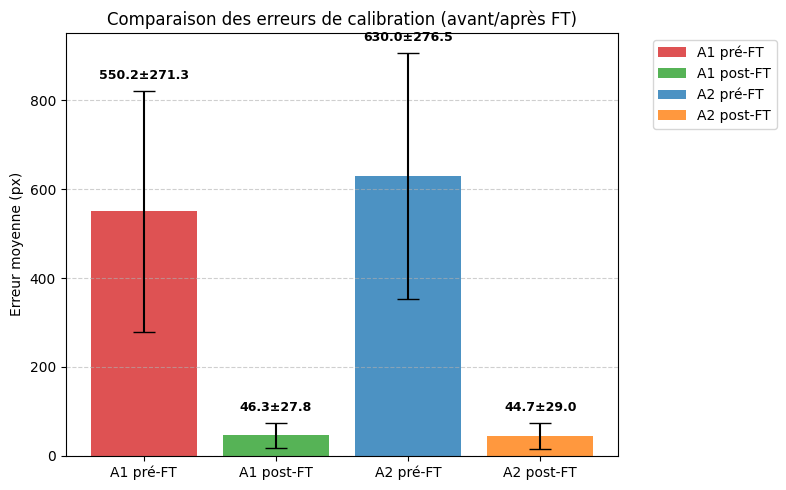

In [ ]:
# summary_stats_compare.py — A1 conservé, A2 = nouvelle session
import statistics as stats
import math

W, H = 2560, 1440

# ---- A1  ----
A1_PRE_MEAN, A1_PRE_STD = 550.2, 271.3
A1_POST_MEAN, A1_POST_STD = 46.3, 27.8

# ---- A2 (normalisé -> pixels) ----
t_pre = [
 (0.09,0.09),(0.23,0.23),(0.45,0.09),(0.68,0.23),(0.82,0.09),
 (0.09,0.45),(0.27,0.45),(0.46,0.27),(0.45,0.45),(0.45,0.64),
 (0.64,0.46),(0.82,0.45),(0.09,0.82),(0.23,0.68),(0.45,0.82),
 (0.68,0.68),(0.82,0.82)
]
p_pre = [
 (0.35,0.05),(0.42,0.06),(0.55,0.25),(0.63,0.22),(0.68,0.26),
 (0.36,0.06),(0.42,0.07),(0.50,0.21),(0.51,0.15),(0.48,0.19),
 (0.60,0.18),(0.59,0.22),(0.15,0.09),(0.44,0.11),(0.57,0.17),
 (0.64,0.15),(0.68,0.25)
]
p_post = [
 (0.12,0.11),(0.21,0.19),(0.47,0.15),(0.67,0.21),(0.81,0.10),
 (0.10,0.45),(0.26,0.48),(0.44,0.27),(0.46,0.44),(0.44,0.66),
 (0.65,0.46),(0.78,0.45),(0.09,0.81),(0.23,0.68),(0.46,0.81),
 (0.68,0.69),(0.80,0.82)
]

def euclid_errs(t, p):
    return [math.hypot(px-tx, py-ty) for (tx,ty),(px,py) in zip(t,p)]

t_px  = denorm_pixels(t_pre, W, H)
pre_px  = denorm_pixels(p_pre, W, H)
post_px = denorm_pixels(p_post, W, H)

A2_PRE_MEAN = stats.mean(euclid_errs(t_px, pre_px))
A2_PRE_STD  = stats.pstdev(euclid_errs(t_px, pre_px))
A2_POST_MEAN = stats.mean(euclid_errs(t_px, post_px))
A2_POST_STD  = stats.pstdev(euclid_errs(t_px, post_px))

print(f"A1 pre: mean={A1_PRE_MEAN:.1f}px, std={A1_PRE_STD:.1f}px")
print(f"A1 post: mean={A1_POST_MEAN:.1f}px, std={A1_POST_STD:.1f}px")
print(f"A2 pre: mean={A2_PRE_MEAN:.1f}px, std={A2_PRE_STD:.1f}px")
print(f"A2 post: mean={A2_POST_MEAN:.1f}px, std={A2_POST_STD:.1f}px")

# (Option) barplot comparatif à jour
try:
    import matplotlib.pyplot as plt
    import numpy as np
    labels = ["A1 pré-FT", "A1 post-FT", "A2 pré-FT", "A2 post-FT"]
    means = [A1_PRE_MEAN, A1_POST_MEAN, A2_PRE_MEAN, A2_POST_MEAN]
    stds  = [A1_PRE_STD,  A1_POST_STD,  A2_PRE_STD,  A2_POST_STD]

    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(x, means, yerr=stds, capsize=8,
                  color=["#d62728","#2ca02c","#1f77b4","#ff7f0e"], alpha=0.8)
    for i,(m,s) in enumerate(zip(means,stds)):
        ax.text(i, m + s + 20, f"{m:.1f}±{s:.1f}", ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax.set_ylabel("Erreur moyenne (px)")
    ax.set_title("Comparaison des erreurs de calibration (avant/après FT)")
    ax.set_xticks(x); ax.set_xticklabels(labels)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend(bars, labels, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.savefig("figures/comparaison_approches_barplot.pdf")
    # plt.show()
except Exception as e:
    print("Barplot non généré:", e)
